# read

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder # LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

train = pd.read_csv('./train_df.csv', encoding='cp949')
test  = pd.read_csv('./test_df.csv', encoding='cp949')
sub   = pd.read_csv('./sample_submission.csv', encoding='cp949')

In [2]:
test.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM
0,32000,5013000043028400,1165000021097200,식품,농산물
1,32001,5013000044016100,1154500002066400,식품,농산물
2,32002,5013000205030200,4139000102013200,식품,농산물
3,32003,5013000205030200,4221000040093400,식품,농산물
4,32004,5013000268011400,2726000004017100,식품,농산물


In [3]:
train.shape, test.shape, sub.shape

((32000, 6), (4640, 5), (4640, 2))

In [4]:
train.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT
0,0,1129000014045300,5011000220046300,패션의류,상의,3
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9
3,3,1154500002014200,5011000315087400,식품,농산물,10
4,4,1165000021008300,5011000177051200,식품,가공식품,3


In [5]:
test.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM
0,32000,5013000043028400,1165000021097200,식품,농산물
1,32001,5013000044016100,1154500002066400,식품,농산물
2,32002,5013000205030200,4139000102013200,식품,농산물
3,32003,5013000205030200,4221000040093400,식품,농산물
4,32004,5013000268011400,2726000004017100,식품,농산물


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          32000 non-null  int64 
 1   SEND_SPG_INNB  32000 non-null  int64 
 2   REC_SPG_INNB   32000 non-null  int64 
 3   DL_GD_LCLS_NM  32000 non-null  object
 4   DL_GD_MCLS_NM  32000 non-null  object
 5   INVC_CONT      32000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.5+ MB


In [7]:
train.isnull().sum()

index            0
SEND_SPG_INNB    0
REC_SPG_INNB     0
DL_GD_LCLS_NM    0
DL_GD_MCLS_NM    0
INVC_CONT        0
dtype: int64

In [8]:
test.isnull().sum()

index            0
SEND_SPG_INNB    0
REC_SPG_INNB     0
DL_GD_LCLS_NM    0
DL_GD_MCLS_NM    0
dtype: int64

<AxesSubplot:xlabel='SEND_SPG_INNB', ylabel='Density'>

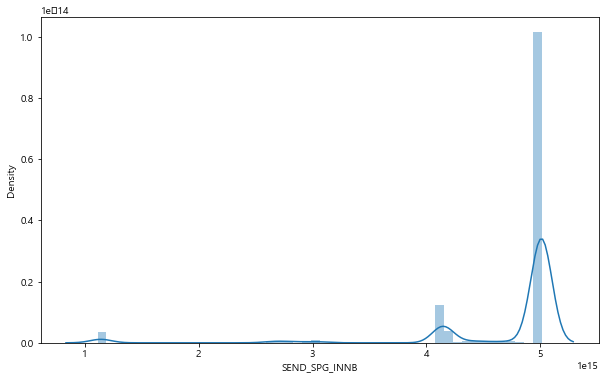

In [9]:
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(train["SEND_SPG_INNB"])

Skewness: -4.561
Kurtosis: 21.404


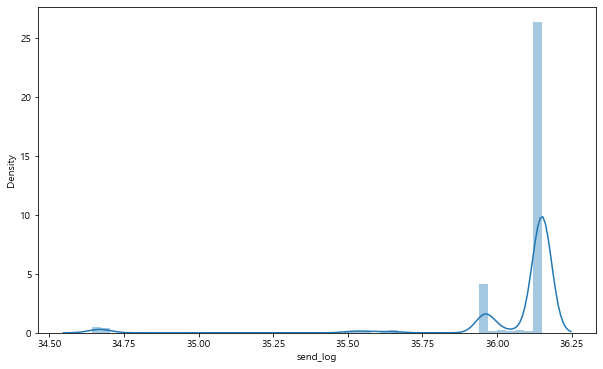

In [10]:
train["send_log"] = np.log1p(train["SEND_SPG_INNB"]) 
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(train["send_log"]) 
print("Skewness: {:.3f}".format(train["send_log"].skew()))
print("Kurtosis: {:.3f}".format(train["send_log"].kurt()))

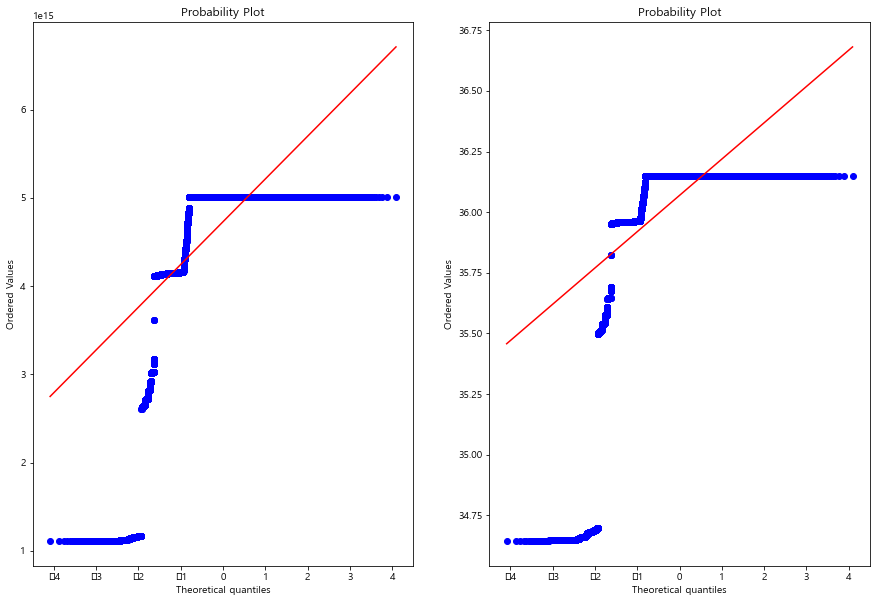

In [11]:
from scipy import stats 
fig = plt.figure(figsize = (15,10)) 
fig.add_subplot(1,2,1) 
res = stats.probplot(train['SEND_SPG_INNB'], plot=plt) 
fig.add_subplot(1,2,2) 
res = stats.probplot(train['send_log'], plot=plt)

In [12]:
train['SEND_SPG_INNB'].head(35) # 11:5, 9:7, 7:4:5, 10:6

0     1129000014045300
1     1135000009051200
2     1135000030093100
3     1154500002014200
4     1165000021008300
5     1168000013091300
6     1171000019003100
7     2623000012072300
8     2626000011052400
9     2726000034007300
10    2729000029060300
11    2811000069044300
12    2820000053057300
13    2914000013007300
14    3023000012008100
15    3023000012008100
16    3023000012008100
17    4111300037051300
18    4119900009063300
19    4119900009063300
20    4119900009063300
21    4121000015010300
22    4121000015010300
23    4122000151090400
24    4127300065073100
25    4128500028049400
26    4136000185087300
27    4136000216029100
28    4136000216029100
29    4136000216029100
30    4136000216029100
31    4141000031009400
32    4141000031030100
33    4141000031030100
34    4141000031030100
Name: SEND_SPG_INNB, dtype: int64

## 시도(2)+시군구(3)+읍면동(3)+리(2)

In [13]:
# train['send_2'] = train["SEND_SPG_INNB"].astype('str').str[:2].astype('int64')
# test['send_2'] = test["SEND_SPG_INNB"].astype('str').str[:2].astype('int64')

# train['send_5'] = train["SEND_SPG_INNB"].astype('str').str[:5].astype('int64')
# test['send_5'] = test["SEND_SPG_INNB"].astype('str').str[:5].astype('int64')

# train['send_8'] = train["SEND_SPG_INNB"].astype('str').str[:8].astype('int64')
# test['send_8'] = test["SEND_SPG_INNB"].astype('str').str[:8].astype('int64')

# train['send_10'] = train["SEND_SPG_INNB"].astype('str').str[:10].astype('int64')
# test['send_10'] = test["SEND_SPG_INNB"].astype('str').str[:10].astype('int64')

# train['send_back_6'] = train["SEND_SPG_INNB"].astype('str').str[-6:].astype('int64')
# test['send_back_6'] = test["SEND_SPG_INNB"].astype('str').str[-6:].astype('int64')

In [14]:
# # train['send_1'] = train["SEND_SPG_INNB"].astype('str').str[:1].astype('int64')
# # train['send_2'] = train["SEND_SPG_INNB"].astype('str').str[:2].astype('int64')
# train['send_3'] = train["SEND_SPG_INNB"].astype('str').str[:3].astype('int64')
# train['send_4'] = train["SEND_SPG_INNB"].astype('str').str[:4].astype('int64')
# train['send_5'] = train["SEND_SPG_INNB"].astype('str').str[:5].astype('int64')
# # train['send_6'] = train["SEND_SPG_INNB"].astype('str').str[:6].astype('int64')
# train['send_7'] = train["SEND_SPG_INNB"].astype('str').str[:7].astype('int64')
# train['send_8'] = train["SEND_SPG_INNB"].astype('str').str[:8].astype('int64')
# train['send_9'] = train["SEND_SPG_INNB"].astype('str').str[:9].astype('int64')
# # train['send_10'] = train["SEND_SPG_INNB"].astype('str').str[:10].astype('int64')
# # train['send_11'] = train["SEND_SPG_INNB"].astype('str').str[:11].astype('int64')
# # train['send_12'] = train["SEND_SPG_INNB"].astype('str').str[:12].astype('int64')
# # train['send_13'] = train["SEND_SPG_INNB"].astype('str').str[:13].astype('int64')
# # train['send_14'] = train["SEND_SPG_INNB"].astype('str').str[:14].astype('int64')
# # train['send_15'] = train["SEND_SPG_INNB"].astype('str').str[:15].astype('int64')
# # train['send_16'] = train["SEND_SPG_INNB"].astype('str').str[:16].astype('int64')

# # train['send_2'] = train["SEND_SPG_INNB"].astype('str').str[:2].astype('int64')
# # train['send_5'] = train["SEND_SPG_INNB"].astype('str').str[:5].astype('int64')

# # train['send_5_8'] = train["SEND_SPG_INNB"].astype('str').str[5:8].astype('int64') # 읍면동
# # train['send_8_10'] = train["SEND_SPG_INNB"].astype('str').str[8:10].astype('int64') # 리

# # test['send_5_8'] = test["SEND_SPG_INNB"].astype('str').str[5:8].astype('int64')
# # test['send_8_10'] = test["SEND_SPG_INNB"].astype('str').str[8:10].astype('int64')


# train.hist(figsize=(10, 10))

In [15]:
# print(train['send_2'].nunique()) 
# # print(train['send_3'].nunique()) # 64
# # print(train['send_4'].nunique()) # 213 
# print(train['send_5'].nunique()) # 234
# # print(train['send_6'].nunique())
# # print(train['send_7'].nunique()) # 240
# print(train['send_8'].nunique()) # 511
# # print(train['send_9'].nunique()) # 1161
# print(train['send_10'].nunique())


# 격자고유번호 선별

In [16]:
# for slice in range(1, 17):
#     train['rec_' + str(slice)] = train['REC_SPG_INNB'].astype('str').str[:slice].astype('int64')
#     train['send_' + str(slice)] = train["SEND_SPG_INNB"].astype('str').str[:slice].astype('int64')
    
#     test['rec_' + str(slice)] = test['REC_SPG_INNB'].astype('str').str[:slice].astype('int64')
#     test['send_' + str(slice)] = test["SEND_SPG_INNB"].astype('str').str[:slice].astype('int64')

# for slice in range(1, 17):
#     print('send_' + str(slice), train['send_' + str(slice)].nunique())
# for slice in range(1, 17):
#     print('rec_' + str(slice), train['rec_' + str(slice)].nunique())

<pre>
unique 갯수가 20 이하인 애들 + unique 갯수가 비슷하거나 같은 애들은 삭제

<!-- send_1 5
send_2 17 -->
send_3 64
send_4 213
send_5 234
<!-- send_6 234 -->
send_7 240
send_8 511
send_9 1161
<!-- send_10 2069 -->
send_11 2082
send_12 3081
<!-- send_13 3581 -->
send_14 3684
<!-- send_15 3684 -->
<!-- send_16 3684 -->

<!-- rec_1 5
rec_2 17 -->
rec_3 65
rec_4 229
rec_5 251
<!-- rec_6 251 -->
<!-- rec_7 268 -->
rec_8 979
rec_9 3353
rec_10 7739
<!-- rec_11 7945 -->
rec_12 19039
<!-- rec_13 26039 -->
rec_14 27826
<!-- rec_15 27826 -->
<!-- rec_16 27826 -->

</pre>

In [17]:
slices = [3, 4, 7, 8, 9, 11, 12, 14]

for slice in slices:
    train['rec_' + str(slice)] = train['REC_SPG_INNB'].astype('str').str[:slice].astype('int64')
    train['send_' + str(slice)] = train["SEND_SPG_INNB"].astype('str').str[:slice].astype('int64')
    
    test['rec_' + str(slice)] = test['REC_SPG_INNB'].astype('str').str[:slice].astype('int64')
    test['send_' + str(slice)] = test["SEND_SPG_INNB"].astype('str').str[:slice].astype('int64')

In [18]:
# # train['rec_2'] = train["REC_SPG_INNB"].astype('str').str[:2].astype('int64')
# train['rec_3'] = train["REC_SPG_INNB"].astype('str').str[:3].astype('int64')
# train['rec_4'] = train["REC_SPG_INNB"].astype('str').str[:4].astype('int64')
# train['rec_5'] = train["REC_SPG_INNB"].astype('str').str[:5].astype('int64')
# # train['rec_6'] = train["REC_SPG_INNB"].astype('str').str[:6].astype('int64')
# train['rec_7'] = train["REC_SPG_INNB"].astype('str').str[:7].astype('int64')
# train['rec_8'] = train["REC_SPG_INNB"].astype('str').str[:8].astype('int64')
# train['rec_9'] = train["REC_SPG_INNB"].astype('str').str[:9].astype('int64')
# # train['rec_10'] = train["REC_SPG_INNB"].astype('str').str[:10].astype('int64')

In [19]:
# print(train['rec_2'].nunique()) # 17
# # print(train['rec_3'].nunique()) # 65
# # print(train['rec_4'].nunique()) # 229
# print(train['rec_5'].nunique()) # 251
# # print(train['rec_6'].nunique())
# # print(train['rec_7'].nunique()) # 268
# print(train['rec_8'].nunique()) # 979
# # print(train['rec_9'].nunique()) # 3353
# print(train['rec_10'].nunique()) # 7739

In [20]:
# # test['send_2'] = test["SEND_SPG_INNB"].astype('str').str[:2].astype('int64')
# test['send_3'] = test["SEND_SPG_INNB"].astype('str').str[:3].astype('int64')
# test['send_4'] = test["SEND_SPG_INNB"].astype('str').str[:4].astype('int64')
# test['send_5'] = test["SEND_SPG_INNB"].astype('str').str[:5].astype('int64')
# # test['send_6'] = test["SEND_SPG_INNB"].astype('str').str[:6].astype('int64')
# test['send_7'] = test["SEND_SPG_INNB"].astype('str').str[:7].astype('int64')
# test['send_8'] = test["SEND_SPG_INNB"].astype('str').str[:8].astype('int64')
# test['send_9'] = test["SEND_SPG_INNB"].astype('str').str[:9].astype('int64')
# # test['send_10'] = test["SEND_SPG_INNB"].astype('str').str[:10].astype('int64')

In [21]:
# # test['rec_2'] = test["REC_SPG_INNB"].astype('str').str[:2].astype('int64')
# test['rec_3'] = test["REC_SPG_INNB"].astype('str').str[:3].astype('int64')
# test['rec_4'] = test["REC_SPG_INNB"].astype('str').str[:4].astype('int64')
# test['rec_5'] = test["REC_SPG_INNB"].astype('str').str[:5].astype('int64')
# # test['rec_6'] = test["REC_SPG_INNB"].astype('str').str[:6].astype('int64')
# test['rec_7'] = test["REC_SPG_INNB"].astype('str').str[:7].astype('int64')
# test['rec_8'] = test["REC_SPG_INNB"].astype('str').str[:8].astype('int64')
# test['rec_9'] = test["REC_SPG_INNB"].astype('str').str[:9].astype('int64')
# # test['rec_10'] = test["REC_SPG_INNB"].astype('str').str[:10].astype('int64')

In [22]:
# train['rec_2'] = train["REC_SPG_INNB"].astype('str').str[:2].astype('int64')
# test['rec_2'] = test["REC_SPG_INNB"].astype('str').str[:2].astype('int64')

# train['rec_5'] = train["REC_SPG_INNB"].astype('str').str[:5].astype('int64')
# test['rec_5'] = test["REC_SPG_INNB"].astype('str').str[:5].astype('int64')

# train['rec_8'] = train["REC_SPG_INNB"].astype('str').str[:8].astype('int64')
# test['rec_8'] = test["REC_SPG_INNB"].astype('str').str[:8].astype('int64')

# train['rec_10'] = train["REC_SPG_INNB"].astype('str').str[:10].astype('int64')
# test['rec_10'] = test["REC_SPG_INNB"].astype('str').str[:10].astype('int64')

# train['rec_back_6'] = train["REC_SPG_INNB"].astype('str').str[-6:].astype('int64')
# test['rec_back_6'] = test["REC_SPG_INNB"].astype('str').str[-6:].astype('int64')

<AxesSubplot:>

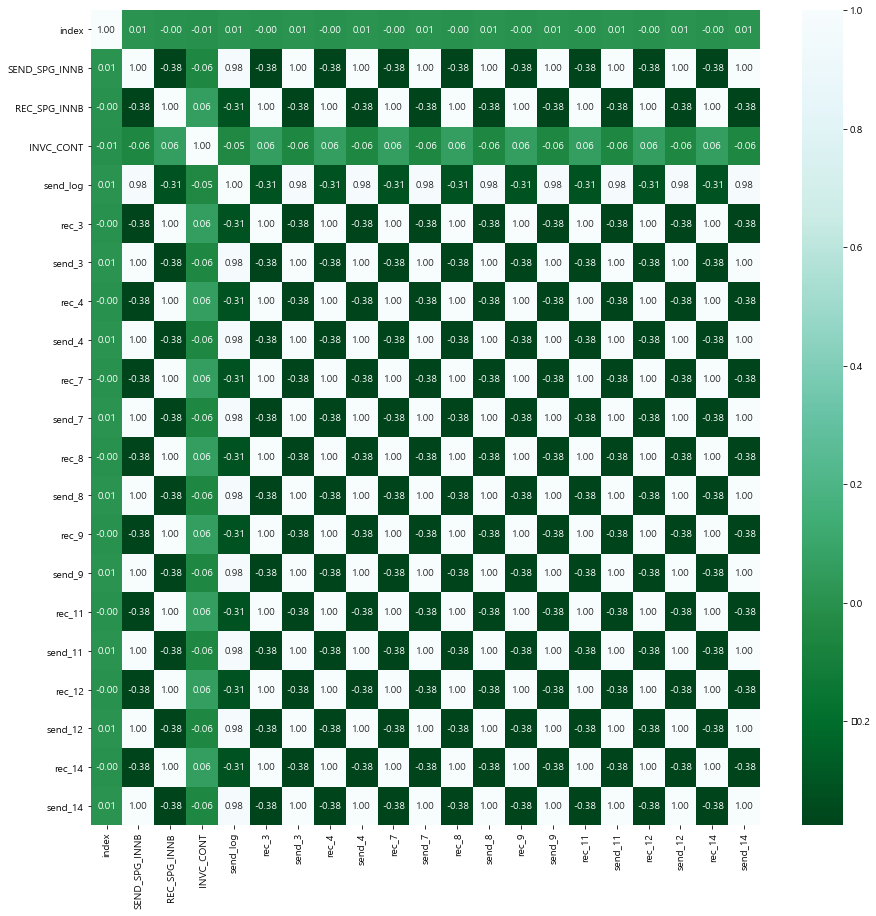

In [23]:
plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), fmt='.2f', annot=True, cmap= 'BuGn_r')

## 배송지역이 같거나 다를때의 운송량 확인

In [24]:
train[train['SEND_SPG_INNB']==train['REC_SPG_INNB']]['INVC_CONT'].count()

37

In [25]:
train[train['SEND_SPG_INNB']!=train['REC_SPG_INNB']]['INVC_CONT'].count()

31963

In [26]:
# SEND_SPG_INNB != REC_SPG_INNB

idxs = train[train['SEND_SPG_INNB'] != train['REC_SPG_INNB']].index
train['not_same'] = 0

for idx in idxs:
    train.loc[idx, 'not_same'] = 1

idxs = test[test['SEND_SPG_INNB'] != test['REC_SPG_INNB']].index
test['not_same'] = 0

for idx in idxs:
    test.loc[idx, 'not_same'] = 1

## 제주도 간 물류 유통

In [27]:
train['send_1'] = train["SEND_SPG_INNB"].astype('str').str[:1].astype('int64')
train['rec_1'] = train["REC_SPG_INNB"].astype('str').str[:1].astype('int64')

test['send_1'] = test["SEND_SPG_INNB"].astype('str').str[:1].astype('int64') 
test['rec_1'] = test["REC_SPG_INNB"].astype('str').str[:1].astype('int64')

In [28]:
train['send_2'] = train["SEND_SPG_INNB"].astype('str').str[:2].astype('int64')
train['rec_2'] = train["REC_SPG_INNB"].astype('str').str[:2].astype('int64')

test['send_2'] = test["SEND_SPG_INNB"].astype('str').str[:2].astype('int64')
test['rec_2'] = test["REC_SPG_INNB"].astype('str').str[:2].astype('int64')

In [29]:
# train['send_3'] = train["SEND_SPG_INNB"].astype('str').str[:3].astype('int64')
# train['rec_3'] = train["REC_SPG_INNB"].astype('str').str[:3].astype('int64')

# test['send_3'] = test["SEND_SPG_INNB"].astype('str').str[:3].astype('int64')
# test['rec_3'] = test["REC_SPG_INNB"].astype('str').str[:3].astype('int64')

In [30]:
print(train[train['send_1']==5][['send_1', 'SEND_SPG_INNB']].shape)
print(train[train['send_2']==50][['send_2', 'SEND_SPG_INNB']].shape)
print(train[train['send_3']==501][['send_3', 'SEND_SPG_INNB']].shape) # 5: 제주도

(25344, 2)
(25344, 2)
(25344, 2)


In [31]:
jeju_idx = train[(train['send_1'] == 5) & (train['rec_1'] == 5)].index # ['INVC_CONT'].count()

train['jeju'] = 0

for idx in jeju_idx:
    train.loc[idx, 'jeju'] = 1

In [32]:
jeju_idx = test[(test['send_1'] == 5) & (test['rec_1'] == 5)].index # ['INVC_CONT'].count()

test['jeju'] = 0

for idx in jeju_idx:
    test.loc[idx, 'jeju'] = 1

## 유통량 가장 많은 send_1 가중치

In [33]:
# 5
train.groupby('send_1').count()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False)

,INVC_CONT
send_1,
5,25344
4,4984
1,859
2,550
3,263


In [34]:
train['send_1_plus'] = 0
train.loc[train['send_1']==5, 'send_1_plus'] = 1

test['send_1_plus'] = 0
test.loc[test['send_1']==5, 'send_1_plus'] = 1

In [35]:
# 4
train.groupby('rec_1').count()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False)

,INVC_CONT
rec_1,
4,14260
5,6833
1,4984
2,4514
3,1409


In [36]:
train['rec_1_plus'] = 0
train.loc[train['rec_1']==4, 'rec_1_plus'] = 1

test['rec_1_plus'] = 0
test.loc[test['rec_1']==4, 'rec_1_plus'] = 1

## 운송량 많은 중분류 or 대분류에 가중치

In [37]:
train.groupby('DL_GD_MCLS_NM').count()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False)

,INVC_CONT
DL_GD_MCLS_NM,
농산물,22162
문화컨텐츠,1192
음료,1126
수산,931
가공식품,923
기타식품,766
건강식품,651
음반,635
축산,418


In [38]:
train['farm_plus'] = 0
train.loc[train['DL_GD_MCLS_NM'] == '농산물', 'farm_plus'] = 1
train.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT,send_log,rec_3,send_3,rec_4,send_4,rec_7,send_7,rec_8,send_8,rec_9,send_9,rec_11,send_11,rec_12,send_12,rec_14,send_14,not_same,send_1,rec_1,send_2,rec_2,jeju,send_1_plus,rec_1_plus,farm_plus
0,0,1129000014045300,5011000220046300,패션의류,상의,3,34.660109,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,1,5,11,50,0,0,0,0
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3,34.665409,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,1,5,11,50,0,0,0,0
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9,34.665409,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,1,5,11,50,0,0,0,0
3,3,1154500002014200,5011000315087400,식품,농산물,10,34.682444,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,1,5,11,50,0,0,0,1
4,4,1165000021008300,5011000177051200,식품,가공식품,3,34.691497,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,1,5,11,50,0,0,0,0


In [39]:
test['farm_plus'] = 0
test.loc[test['DL_GD_MCLS_NM'] == '농산물', 'farm_plus'] = 1

In [40]:
train.groupby('DL_GD_LCLS_NM').count()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False)

,INVC_CONT
DL_GD_LCLS_NM,
식품,27738
생활/건강,2020
여행/문화,1192
패션의류,582
디지털/가전,241
화장품/미용,227


In [41]:
train['food_plus'] = 0
train.loc[train['DL_GD_LCLS_NM'] == '식품', 'food_plus'] = 1
train.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT,send_log,rec_3,send_3,rec_4,send_4,rec_7,send_7,rec_8,send_8,rec_9,send_9,rec_11,send_11,rec_12,send_12,rec_14,send_14,not_same,send_1,rec_1,send_2,rec_2,jeju,send_1_plus,rec_1_plus,farm_plus,food_plus
0,0,1129000014045300,5011000220046300,패션의류,상의,3,34.660109,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,1,5,11,50,0,0,0,0,0
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3,34.665409,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,1,5,11,50,0,0,0,0,0
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9,34.665409,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,1,5,11,50,0,0,0,0,0
3,3,1154500002014200,5011000315087400,식품,농산물,10,34.682444,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,1,5,11,50,0,0,0,1,1
4,4,1165000021008300,5011000177051200,식품,가공식품,3,34.691497,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,1,5,11,50,0,0,0,0,1


In [42]:
test['food_plus'] = 0
test.loc[test['DL_GD_LCLS_NM'] == '식품', 'food_plus'] = 1

## 중분류 대분류 mean

In [43]:
train.groupby('DL_GD_MCLS_NM').mean()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False).to_csv('중분류.csv')

In [44]:
mcls = pd.read_csv('중분류.csv')
mcls.rename(columns={'INVC_CONT':'mcls_mean'}, inplace=True )
mcls.head(10)

,DL_GD_MCLS_NM,mcls_mean
0,기타패션의류,10.375479
1,건강용품,10.238636
2,축산,8.196172
3,문구/사무용품,7.900000
4,가공식품,6.807151
5,기타디지털/가전,6.547718
6,기타식품,6.130548
7,건강식품,5.780338
8,과자,5.767241
9,음료,5.745115


In [45]:
train.groupby('DL_GD_LCLS_NM').mean()[['INVC_CONT']].sort_values('INVC_CONT', ascending=False).to_csv('대분류.csv')

In [46]:
lcls = pd.read_csv('대분류.csv')
lcls.rename(columns={'INVC_CONT':'lcls_mean'}, inplace=True )
lcls.head(10)

,DL_GD_LCLS_NM,lcls_mean
0,패션의류,6.678694
1,디지털/가전,6.547718
2,생활/건강,5.407921
3,여행/문화,4.958893
4,화장품/미용,4.682819
5,식품,4.658195


In [47]:
train = pd.merge(train, lcls, how = 'left', on='DL_GD_LCLS_NM') # 대분류
train = pd.merge(train, mcls, how = 'left', on='DL_GD_MCLS_NM') # 중분류
train

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT,send_log,rec_3,send_3,rec_4,send_4,rec_7,send_7,rec_8,send_8,rec_9,send_9,rec_11,send_11,rec_12,send_12,rec_14,send_14,not_same,send_1,rec_1,send_2,rec_2,jeju,send_1_plus,rec_1_plus,farm_plus,food_plus,lcls_mean,mcls_mean
0,0,1129000014045300,5011000220046300,패션의류,상의,3,34.660109,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,1,5,11,50,0,0,0,0,0,6.678694,3.672897
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3,34.665409,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,1,5,11,50,0,0,0,0,0,5.407921,4.444134
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9,34.665409,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,1,5,11,50,0,0,0,0,0,6.678694,10.375479
3,3,1154500002014200,5011000315087400,식품,농산물,10,34.682444,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,1,5,11,50,0,0,0,1,1,4.658195,4.297401
4,4,1165000021008300,5011000177051200,식품,가공식품,3,34.691497,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,1,5,11,50,0,0,0,0,1,4.658195,6.807151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,31995,5011001060063300,2635000026053400,식품,농산물,6,36.150412,263,501,2635,5011,2635000,5011001,26350000,50110010,263500002,501100106,26350000260,50110010600,263500002605,501100106006,26350000260534,50110010600633,1,5,2,50,26,0,1,0,1,1,4.658195,4.297401
31996,31996,5011001095042400,1168000017002200,식품,기타식품,5,36.150412,116,501,1168,5011,1168000,5011001,11680000,50110010,116800001,501100109,11680000170,50110010950,116800001700,501100109504,11680000170022,50110010950424,1,5,1,50,11,0,1,0,0,1,4.658195,6.130548
31997,31997,5011001108036200,4119700008012100,식품,농산물,9,36.150412,411,501,4119,5011,4119700,5011001,41197000,50110011,411970000,501100110,41197000080,50110011080,411970000801,501100110803,41197000080121,50110011080362,1,5,4,50,41,0,1,1,1,1,4.658195,4.297401
31998,31998,5011001115011400,1132000015085100,식품,농산물,3,36.150412,113,501,1132,5011,1132000,5011001,11320000,50110011,113200001,501100111,11320000150,50110011150,113200001508,501100111501,11320000150851,50110011150114,1,5,1,50,11,0,1,0,1,1,4.658195,4.297401


In [48]:
test = pd.merge(test, lcls, how = 'left', on='DL_GD_LCLS_NM') # 대분류
test = pd.merge(test, mcls, how = 'left', on='DL_GD_MCLS_NM') # 중분류
test

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,rec_3,send_3,rec_4,send_4,rec_7,send_7,rec_8,send_8,rec_9,send_9,rec_11,send_11,rec_12,send_12,rec_14,send_14,not_same,send_1,rec_1,send_2,rec_2,jeju,send_1_plus,rec_1_plus,farm_plus,food_plus,lcls_mean,mcls_mean
0,32000,5013000043028400,1165000021097200,식품,농산물,116,501,1165,5013,1165000,5013000,11650000,50130000,116500002,501300004,11650000210,50130000430,116500002109,501300004302,11650000210972,50130000430284,1,5,1,50,11,0,1,0,1,1,4.658195,4.297401
1,32001,5013000044016100,1154500002066400,식품,농산물,115,501,1154,5013,1154500,5013000,11545000,50130000,115450000,501300004,11545000020,50130000440,115450000206,501300004401,11545000020664,50130000440161,1,5,1,50,11,0,1,0,1,1,4.658195,4.297401
2,32002,5013000205030200,4139000102013200,식품,농산물,413,501,4139,5013,4139000,5013000,41390001,50130002,413900010,501300020,41390001020,50130002050,413900010201,501300020503,41390001020132,50130002050302,1,5,4,50,41,0,1,1,1,1,4.658195,4.297401
3,32003,5013000205030200,4221000040093400,식품,농산물,422,501,4221,5013,4221000,5013000,42210000,50130002,422100004,501300020,42210000400,50130002050,422100004009,501300020503,42210000400934,50130002050302,1,5,4,50,42,0,1,1,1,1,4.658195,4.297401
4,32004,5013000268011400,2726000004017100,식품,농산물,272,501,2726,5013,2726000,5013000,27260000,50130002,272600000,501300026,27260000040,50130002680,272600000401,501300026801,27260000040171,50130002680114,1,5,2,50,27,0,1,0,1,1,4.658195,4.297401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4635,36635,5013000858004400,4725000719072200,식품,농산물,472,501,4725,5013,4725000,5013000,47250007,50130008,472500071,501300085,47250007190,50130008580,472500071907,501300085800,47250007190722,50130008580044,1,5,4,50,47,0,1,1,1,1,4.658195,4.297401
4636,36636,5013000870018300,2826000106075300,식품,농산물,282,501,2826,5013,2826000,5013000,28260001,50130008,282600010,501300087,28260001060,50130008700,282600010607,501300087001,28260001060753,50130008700183,1,5,2,50,28,0,1,0,1,1,4.658195,4.297401
4637,36637,5013000897086300,4311100034004300,식품,농산물,431,501,4311,5013,4311100,5013000,43111000,50130008,431110003,501300089,43111000340,50130008970,431110003400,501300089708,43111000340043,50130008970863,1,5,4,50,43,0,1,1,1,1,4.658195,4.297401
4638,36638,5013000902065100,4145000013011200,식품,농산물,414,501,4145,5013,4145000,5013000,41450000,50130009,414500001,501300090,41450000130,50130009020,414500001301,501300090206,41450000130112,50130009020651,1,5,4,50,41,0,1,1,1,1,4.658195,4.297401


In [49]:
# 반올림

train['lcls_mean'] = np.round(train['lcls_mean'], 0).astype('int')
test['lcls_mean'] = np.round(test['lcls_mean'], 0).astype('int')

train['mcls_mean'] = np.round(train['mcls_mean'], 0).astype('int')
test['mcls_mean'] = np.round(test['mcls_mean'], 0).astype('int')

# Drop

In [50]:
train.drop(['SEND_SPG_INNB', 'REC_SPG_INNB', 'DL_GD_MCLS_NM', 'DL_GD_LCLS_NM', 'index', 'send_1', 'send_2', 'rec_1', 'rec_2', 'send_log'], axis=1, inplace=True) # 
test.drop(['SEND_SPG_INNB', 'REC_SPG_INNB', 'DL_GD_MCLS_NM', 'DL_GD_LCLS_NM', 'index', 'send_1', 'send_2', 'rec_1', 'rec_2'], axis=1, inplace=True) # 'SEND_SPG_INNB', 'REC_SPG_INNB', 

# Encoding

In [51]:
obj_cols = []
for col in train.columns:
    if train[col].dtype == 'object':
        obj_cols.append(col)

print(obj_cols)

[]


In [52]:
# encoder = OrdinalEncoder()
# train[['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM']] = encoder.fit_transform(train[['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM']])

# train = pd.get_dummies(train)
# test  = pd.get_dummies(test)

In [53]:
train.head()

,INVC_CONT,rec_3,send_3,rec_4,send_4,rec_7,send_7,rec_8,send_8,rec_9,send_9,rec_11,send_11,rec_12,send_12,rec_14,send_14,not_same,jeju,send_1_plus,rec_1_plus,farm_plus,food_plus,lcls_mean,mcls_mean
0,3,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,0,0,0,0,0,7,4
1,3,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,0,0,0,0,0,5,4
2,9,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,0,0,0,0,0,7,10
3,10,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,0,0,0,1,1,5,4
4,3,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,0,0,0,0,1,5,7


<AxesSubplot:>

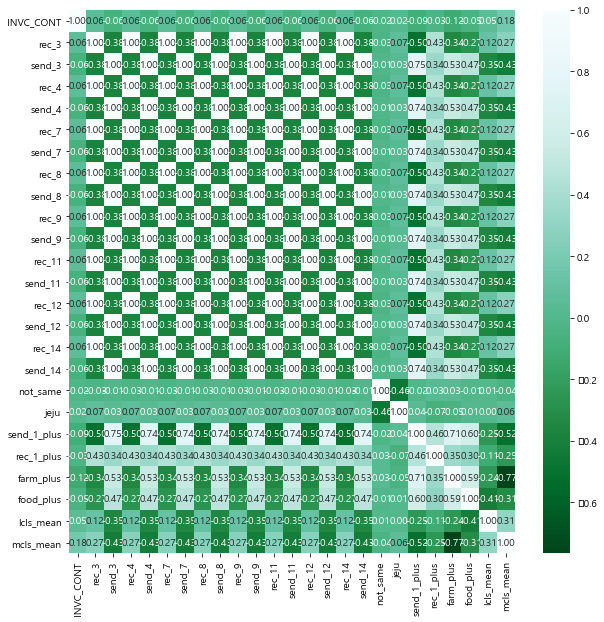

In [54]:
plt.subplots(figsize=(10,10))
sns.heatmap(train.corr(), fmt='.2f', annot=True, cmap= 'BuGn_r')

In [55]:
cols = train.columns

In [56]:
dis_cols=[]   #이산형 
cont_cols=[]  #연속형
for col in cols:
    if(train[col].nunique() < 21):
        dis_cols.append(col)
    else:
        cont_cols.append(col)

이산형
not_same 		 2 		 [1 0]
jeju 		 2 		 [0 1]
send_1_plus 		 2 		 [0 1]
rec_1_plus 		 2 		 [0 1]
farm_plus 		 2 		 [0 1]
food_plus 		 2 		 [0 1]
lcls_mean 		 2 		 [7 5]
mcls_mean 		 6 		 [ 4 10  7  5  6]
----------------------------------------------------------------------------------------------------
연속형
INVC_CONT 		 90 		 [ 3  9 10  5  4]
rec_3 		 65 		 [501 282 112 114 115]
send_3 		 64 		 [112 113 115 116 117]
rec_4 		 229 		 [5011 5013 2826 1123 1147]
send_4 		 213 		 [1129 1135 1154 1165 1168]
rec_7 		 268 		 [5011000 5013000 2826000 1123000 1147000]
send_7 		 240 		 [1129000 1135000 1154500 1165000 1168000]
rec_8 		 979 		 [50110002 50110001 50110003 50110004 50110006]
send_8 		 511 		 [11290000 11350000 11545000 11650000 11680000]
rec_9 		 3353 		 [501100022 501100017 501100026 501100031 501100043]
send_9 		 1161 		 [112900001 113500000 113500003 115450000 116500002]
rec_11 		 7945 		 [50110002200 50110001780 50110002650 50110003150 50110001770]
send_11 		 2082 		 [1129000014

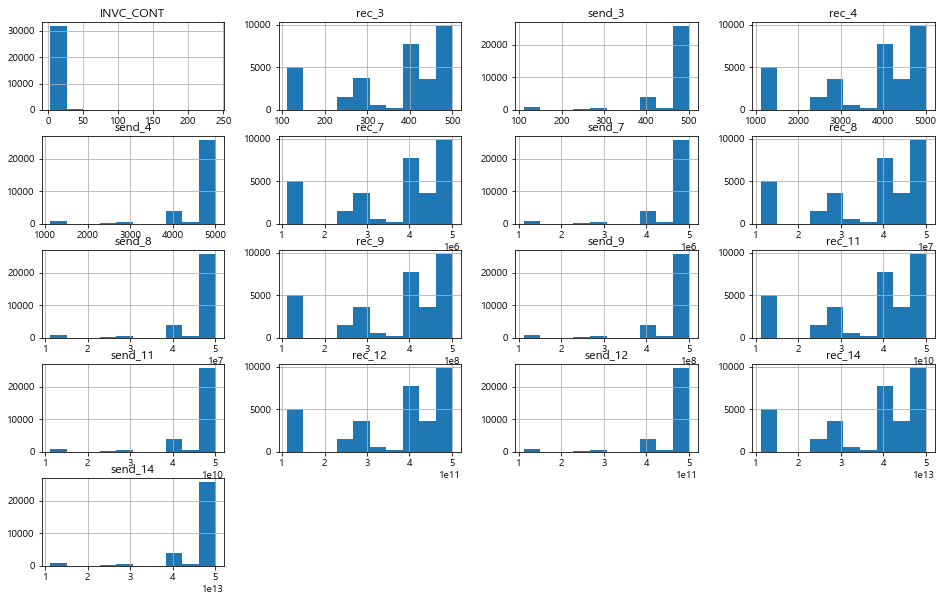

In [57]:
print('이산형')
for col in dis_cols:
    print(f'{col} \t\t {train[col].nunique()} \t\t {train[col].unique()[:5]}')
print("--"*50)
print('연속형')
for col in cont_cols:
    print(f'{col} \t\t {train[col].nunique()} \t\t {train[col].unique()[:5]}')

train[cont_cols].hist(figsize=(16,10))
plt.show()

# for col in dis_cols:
#     train[dis_cols].plot.bar(col)
# plt.show()

In [58]:
# fig = plt.subplots(figsize=(10, 10))
# sns.heatmap(train.corr(), fmt='.4f', annot=True, cmap='Blues')

In [59]:
train.head()

,INVC_CONT,rec_3,send_3,rec_4,send_4,rec_7,send_7,rec_8,send_8,rec_9,send_9,rec_11,send_11,rec_12,send_12,rec_14,send_14,not_same,jeju,send_1_plus,rec_1_plus,farm_plus,food_plus,lcls_mean,mcls_mean
0,3,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,0,0,0,0,0,7,4
1,3,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,0,0,0,0,0,5,4
2,9,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,0,0,0,0,0,7,10
3,10,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,0,0,0,1,1,5,4
4,3,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,0,0,0,0,1,5,7


# Scaler

In [60]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [61]:
# X = train.drop('INVC_CONT',axis = 1)
# y = train['INVC_CONT']

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2)

In [62]:
# scalers = [StandardScaler()] # , MinMaxScaler(), RobustScaler()]
# model = CatBoostRegressor(random_seed= 35)

# for scaler in scalers:
#     scaler.fit(X_train)
#     scaler_X_train = scaler.transform(X_train)
#     scaler_X_val = scaler.transform(X_val)
    
#     print(scaler.__class__.__name__)
#     model.fit(scaler_X_train, y_train)
#     pred = model.predict(scaler_X_val)
#     rmse = mean_squared_error(y_val, pred, squared=False)
#     print('RMSE: ', rmse) # Robust

In [63]:
# scaler= RobustScaler()

In [64]:
# scaler_idx = ['send_10', 'send_back_6', 'rec_10', 'rec_back_6']

# for idx in scaler_idx:
#     train[idx] = scaler.fit_transform(train[idx].values.reshape(-1, 1))
#     test[idx] = scaler.fit_transform(test[idx].values.reshape(-1, 1))

In [65]:
train.head()

,INVC_CONT,rec_3,send_3,rec_4,send_4,rec_7,send_7,rec_8,send_8,rec_9,send_9,rec_11,send_11,rec_12,send_12,rec_14,send_14,not_same,jeju,send_1_plus,rec_1_plus,farm_plus,food_plus,lcls_mean,mcls_mean
0,3,501,112,5011,1129,5011000,1129000,50110002,11290000,501100022,112900001,50110002200,11290000140,501100022004,112900001404,50110002200463,11290000140453,1,0,0,0,0,0,7,4
1,3,501,113,5011,1135,5011000,1135000,50110001,11350000,501100017,113500000,50110001780,11350000090,501100017803,113500000905,50110001780373,11350000090512,1,0,0,0,0,0,5,4
2,9,501,113,5011,1135,5011000,1135000,50110002,11350000,501100026,113500003,50110002650,11350000300,501100026509,113500003009,50110002650914,11350000300931,1,0,0,0,0,0,7,10
3,10,501,115,5011,1154,5011000,1154500,50110003,11545000,501100031,115450000,50110003150,11545000020,501100031508,115450000201,50110003150874,11545000020142,1,0,0,0,1,1,5,4
4,3,501,116,5011,1165,5011000,1165000,50110001,11650000,501100017,116500002,50110001770,11650000210,501100017705,116500002100,50110001770512,11650000210083,1,0,0,0,0,1,5,7


# modeling

In [66]:
# !pip install catboost

In [67]:
X = train.drop('INVC_CONT',axis = 1)
y = train['INVC_CONT']

model = CatBoostRegressor()
param = {}

gscv = GridSearchCV(
    estimator=model, param_grid=param, scoring='neg_root_mean_squared_error', 
    refit=True, cv=5
)
gscv.fit(X,y)

pred = gscv.predict(test)

Learning rate set to 0.069513
0:	learn: 5.4210553	total: 149ms	remaining: 2m 28s
1:	learn: 5.4100106	total: 155ms	remaining: 1m 17s
2:	learn: 5.3986645	total: 160ms	remaining: 53s
3:	learn: 5.3754366	total: 164ms	remaining: 40.8s
4:	learn: 5.3673188	total: 168ms	remaining: 33.5s
5:	learn: 5.3460304	total: 173ms	remaining: 28.7s
6:	learn: 5.3387955	total: 178ms	remaining: 25.2s
7:	learn: 5.3320839	total: 182ms	remaining: 22.6s
8:	learn: 5.3158461	total: 187ms	remaining: 20.6s
9:	learn: 5.3105372	total: 192ms	remaining: 19s
10:	learn: 5.3052635	total: 196ms	remaining: 17.6s
11:	learn: 5.2917623	total: 201ms	remaining: 16.5s
12:	learn: 5.2884753	total: 205ms	remaining: 15.6s
13:	learn: 5.2843813	total: 209ms	remaining: 14.7s
14:	learn: 5.2809157	total: 214ms	remaining: 14s
15:	learn: 5.2723054	total: 218ms	remaining: 13.4s
16:	learn: 5.2673108	total: 223ms	remaining: 12.9s
17:	learn: 5.2642610	total: 228ms	remaining: 12.4s
18:	learn: 5.2611090	total: 233ms	remaining: 12s
19:	learn: 5.2591

In [68]:
# X = train.drop('INVC_CONT',axis = 1)
# y = train['INVC_CONT']

# model = CatBoostRegressor(random_seed=350)

# model.fit(X, y)

# pred = model.predict(test)

In [69]:
pred[:10]

array([4.67494859, 4.73595236, 5.28956392, 6.12759371, 5.29354234,
       5.96172023, 5.17480919, 5.15479607, 5.8053708 , 4.78266054])

In [70]:
sub['INVC_CONT'] = pred

In [71]:
sub.head()

,index,INVC_CONT
0,32000,4.674949
1,32001,4.735952
2,32002,5.289564
3,32003,6.127594
4,32004,5.293542


In [72]:
sub[sub['INVC_CONT']<0]

,index,INVC_CONT


In [73]:
sub.loc[sub['INVC_CONT']<0, 'INVC_CONT'] = 0

# 확인

In [78]:
df = pd.read_csv('sub/submission_v35.csv') # 제일 잘나온 파일
merge= pd.merge(df, sub, how='left', on='index')
merge.head(20)
# merge[merge['INVC_CONT_y']==0]

,index,INVC_CONT_x,INVC_CONT_y
0,32000,4.669381,4.674949
1,32001,4.837141,4.735952
2,32002,5.300440,5.289564
3,32003,6.128668,6.127594
4,32004,5.411674,5.293542
5,32005,5.821277,5.961720
6,32006,5.288457,5.174809
7,32007,5.203556,5.154796
8,32008,5.705150,5.805371
9,32009,4.842111,4.782661


abcdefg

In [77]:
# sub.to_csv('./sub/submission_v36.csv', index=False)

In [79]:
sub28 = pd.read_csv('./sub/submission_v35.csv')
sub29 = pd.read_csv('./sub/submission_v36.csv')
merge= pd.merge(sub28, sub29, how='left', on='index')
merge.head(20)

,index,INVC_CONT_x,INVC_CONT_y
0,32000,4.669381,4.674949
1,32001,4.837141,4.735952
2,32002,5.300440,5.289564
3,32003,6.128668,6.127594
4,32004,5.411674,5.293542
5,32005,5.821277,5.961720
6,32006,5.288457,5.174809
7,32007,5.203556,5.154796
8,32008,5.705150,5.805371
9,32009,4.842111,4.782661
